<img src="./img/画像3.png"><br> 


## データセット

<div style="border:1px solid #000; padding:10px;">
    
本編で扱う creep_data.xlsx" は、177種のTi合金にかかるクリープデータセットです。"creep_data.xlsx" には、合金の組成のほか、クリープの実験条件ならびに熱処理のデータがセットで含まれています。

[1] S. Sucheta, R. Ashish and S. A. Kumar, "Machine learning assisted interpretation of creep and fatigue life in titanium alloys", *APL Machine Learning*, **1**, 016102 (2023)


<br>  
<img src="./img/m_016102_1_f1.jpeg" width="50%"><br> 

---



**Chemical composition** 
1. Titanium (wt %) Ti 
1. Alumunium (wt %) Al 
1. Vanadium (wt %) Vn 
1. Carbon (wt %) C 
1. Nitrogen (wt %) N 
1. Oxygen (wt %) O 
1. Hydrogen (wt %) H 
1. Iron (wt %) Fe 0 
1. Silicon (wt %) Si 
1. Tin (wt %) Sn 
1. Niobium (wt %) Nb 
1. Molybednum (wt %) Mo 
1. Zirconium (wt %) Zr 
1. Boron (wt %) B 
1. Chromium (wt %) Cr 


**Experimental parameters**  
1. Rupture strain (%) ϵr 
1. Temperature of measurement (cel) Tcreep 
1. Steady state strain rate (1/s) ˙ ϵ 
1. Applied stress (MPa) σ 

**Heat treatment conditions**  
1. Aging temperature (cel) Tage 
1. Aging time (hrs) tage 
1. Solution temperature (cel) Tsol
1. Solution time (cel) tsol

### 教材への接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!pip install shap
!git clone https://github.com/ARIM-Usecase/Example_1.git
%cd Example_1

# 1.データセットの読み込みと前処理

### ライブラリのインポート
コード実行で必要なpythonのライブラリをimport文でロードします。

In [1]:
# 汎用ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 機械学習
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import datasets, metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# XAI
import shap

### サンプルファイルの読み込み
pandasライブラリのread_excel()関数は、Excelファイルを読み込んでpandasのDataFrame形式に変換する関数です。ここでは[data]フォルダーにあるcreep_data.xlsxファイルをDataFrame形式でdfという変数に格納します。177のサンプルに対して24の特徴量からなるデータ行列となっています。

In [3]:
# READ DATASET
df = pd.read_excel('./data/creep_data.xlsx')  
df

,Rupture time (hour),Ti,Al,V,Fe,C,N,H,O,Sn,...,B,Cr,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc)
0,0.01000,87.8750,6.75,4.50,0.40,0.100,0.050,0.1250,0.20,0.00,...,0.00,0.0,690,4.0,1050,0.5,700,319.0,2.090000e-03,15.80
1,0.01167,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,...,0.00,0.0,0,0.0,0,0.0,600,319.0,3.240000e-06,0.00
2,0.03050,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,...,0.00,0.0,0,0.0,0,0.0,600,250.0,4.400000e-05,0.00
3,0.04620,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,...,0.00,0.0,0,0.0,0,0.0,500,520.0,4.430000e-05,0.00
4,0.05000,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,...,0.00,0.0,0,0.0,0,0.0,700,319.0,2.130000e-03,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,1160.00000,85.9870,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,...,0.00,0.0,900,1.0,580,8.0,520,310.0,1.200000e-04,0.00
173,1619.00000,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,...,0.00,0.0,0,0.0,940,4.0,455,379.0,9.160000e-07,0.00
174,1744.00000,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,...,0.00,0.0,0,0.0,1030,0.5,455,379.0,1.270000e-06,0.00
175,4681.00000,89.4100,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.00,...,0.00,0.0,0,0.0,0,0.0,538,103.0,9.000000e-07,22.30


## 外れ値の除去
まず、データセットから外れ値（アウトライアー）を除去する処理を行っています。外れ値の除去には幾つかの方法がありますが、ここではzスコアが絶対値で3未満の行（つまり、通常の範囲内にあるデータ）だけを残し、それ以外の行を外れ値として除去する処理を行っています。外れ値が除去された新しいデータフレームを `df_clean` として格納されます。

In [4]:
# Remove outliers from dataset
z_scores = np.abs(stats.zscore(df))
df_clean = df[(z_scores < 3).all(axis=1)]

df_clean

,Rupture time (hour),Ti,Al,V,Fe,C,N,H,O,Sn,...,B,Cr,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc)
1,0.01167,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,...,0.00,0.0,0,0.0,0,0.0,600,319.0,3.240000e-06,0.00
2,0.03050,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,...,0.00,0.0,0,0.0,0,0.0,600,250.0,4.400000e-05,0.00
3,0.04620,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,...,0.00,0.0,0,0.0,0,0.0,500,520.0,4.430000e-05,0.00
5,0.09000,89.2550,6.00,4.00,0.40,0.080,0.050,0.0150,0.20,0.00,...,0.00,0.0,0,0.0,0,0.0,600,319.0,3.520000e-04,26.58
6,0.09580,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,...,0.00,0.0,0,0.0,0,0.0,600,222.0,2.550000e-05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,750.00000,89.3500,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.00,...,0.06,0.0,0,0.0,900,2.0,475,300.0,2.550000e-08,14.22
171,750.00000,85.9870,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,...,0.00,0.0,1050,1.0,550,24.0,520,310.0,1.000000e-05,0.00
172,1160.00000,85.9870,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,...,0.00,0.0,900,1.0,580,8.0,520,310.0,1.200000e-04,0.00
173,1619.00000,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,...,0.00,0.0,0,0.0,940,4.0,455,379.0,9.160000e-07,0.00


【解説】

#### 1. `z_scores = np.abs(stats.zscore(df))`
- **目的:** データセット `df` の各データポイントに対して、標準スコア（zスコア）を計算しています。
- **zスコア (Z-score):** 各データポイントが、そのデータの平均から標準偏差の何倍離れているかを表す指標です。式で表すと、`z = (x - μ) / σ` です。ここで `x` はデータポイント、`μ` は平均、`σ` は標準偏差です。
- **`stats.zscore(df)`:** `df` の各列に対して zスコアを計算し、同じ形状の DataFrame が返されます。
- **`np.abs()`:** zスコアの絶対値を取ります。これにより、負のzスコアも正の値として扱うことができます#。

### 2. `df_clean = df[(z_scores < 3).all(axis=1)]`
- **目的:** zスコアが絶対値で3未満のデータポイントだけを残して、外れ値を除去した新しいデータフレーム `df_clean` を作成します。
- **`z_scores < 3`:** zスコアが3未満であるかどうかをチェックし、真偽値の DataFrame を生成します。
- **`.all(axis=1)`:** 各行について、すべての列で zスコアが3未満であるかどうかを判定します。`axis=1` は行ごとに処理を行う指定です。すべての列が `True` なら、その行は外れ値ではないとみなされます。
- **`df[(z_scores < 3).all(axis=1)]`:** 元のデータフレーム `df` から、zスコアが3未満の行だけを残したデータフレーム `df_clclean` に格納されます。

# 2. データの探索的分析 (EDA)

探索的データ分析 (EDA) は、データに潜むパターンや特徴、関係性を視覚的に捉え、データに対する深い理解を得るための最初のステップです。

### ペアプロット（散布図行列）
ペアプロット（Pair plot）は、データセット内の複数の数値変数の組み合わせに基づいた散布図行列を可視化する手法です。これにより、変数間の相関やパターンを把握することができます。
ペアプロットを作成するライブラリは幾つかありますが、ここではSeabornライブラリの`heatmap()`メソッドを使う方法がとられています。

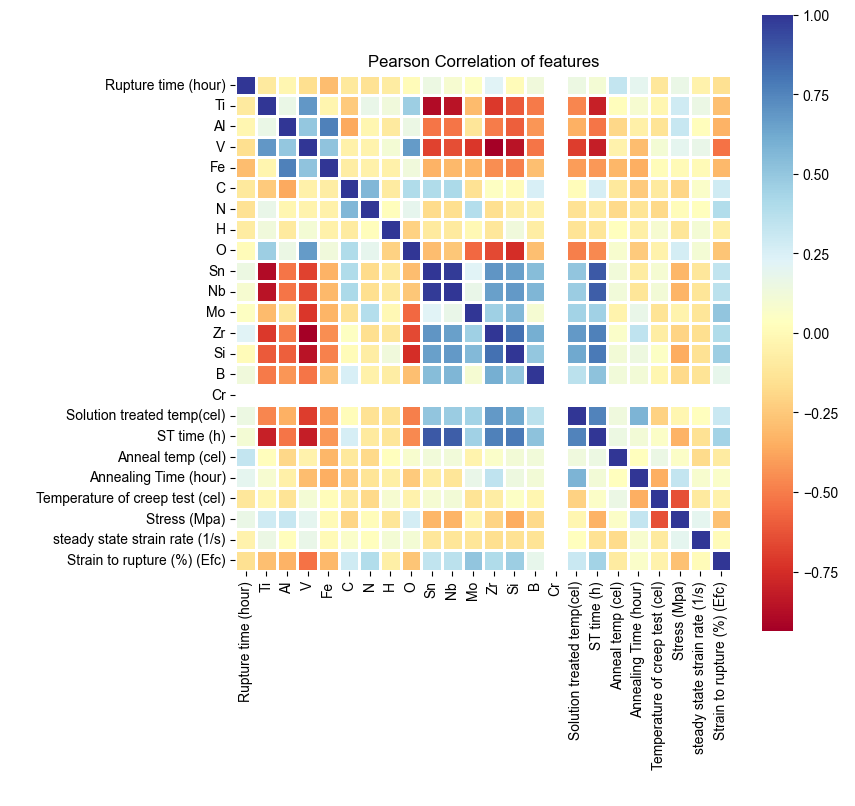

In [5]:
# Plot Pearson Correlation heatmap
plt.figure(figsize=(8, 8))
plt.title('Pearson Correlation of features')

sns.heatmap(df_clean.corr(), 
            linewidths=1.0, 
            vmax=1.0, 
            square=True, 
            cmap="RdYlBu", 
            linecolor='white', 
            annot=False
           )

sns.set(font_scale=1.0)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=0, va="center")

plt.show()

# 3. 特徴量エンジニアリング
次にデータセット `X_clean` の特徴量同士の相関関係を調べ、相関が非常に高い（または非常に低い）特徴量を検出して削除します。相関行列を用いて、しきい値 `0.80` 以上の高相関を持つ特徴量をリストアップし、その特徴量をデータセットから除外することで、冗長な特徴量を減らし、モデルの性能を向上させることが目的です。

次のコードは、ピアソン相関係数（PCC）を使って、高い相関を持つ特徴量をデータセットから選択的に除去を行っています。

In [6]:
# Feature selection using PCC threshold
threshold = 0.80
corr = df_clean.corr()

# Identify and remove highly correlated features
to_drop = [col for i, col in enumerate(corr.columns) 
           if any(abs(corr.iloc[i, :i]) >= threshold)]

df_fin = df_clean.drop(columns=to_drop)
df_fin

,Rupture time (hour),Ti,Al,V,Fe,C,N,H,O,Mo,B,Cr,Solution treated temp(cel),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc)
1,0.01167,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.0,0.00,0.0,0,0,0.0,600,319.0,3.240000e-06,0.00
2,0.03050,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.0,0.00,0.0,0,0,0.0,600,250.0,4.400000e-05,0.00
3,0.04620,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.0,0.00,0.0,0,0,0.0,500,520.0,4.430000e-05,0.00
5,0.09000,89.2550,6.00,4.00,0.40,0.080,0.050,0.0150,0.20,0.0,0.00,0.0,0,0,0.0,600,319.0,3.520000e-04,26.58
6,0.09580,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.0,0.00,0.0,0,0,0.0,600,222.0,2.550000e-05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,750.00000,89.3500,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.0,0.06,0.0,0,900,2.0,475,300.0,2.550000e-08,14.22
171,750.00000,85.9870,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,2.0,0.00,0.0,1050,550,24.0,520,310.0,1.000000e-05,0.00
172,1160.00000,85.9870,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,2.0,0.00,0.0,900,580,8.0,520,310.0,1.200000e-04,0.00
173,1619.00000,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.0,0.00,0.0,0,940,4.0,455,379.0,9.160000e-07,0.00


In [8]:
# final feature set
print(df_fin.columns)  

Index(['Rupture time (hour)', 'Ti', 'Al', 'V', 'Fe', 'C', 'N', 'H', 'O', 'Mo',
       'B', 'Cr', 'Solution treated temp(cel)', 'Anneal temp (cel)',
       'Annealing Time (hour)', 'Temperature of creep test (cel)',
       'Stress (Mpa)', 'steady state strain rate (1/s)',
       'Strain to rupture (%) (Efc)'],
      dtype='object')


【解説】

#### 1. `threshold = 0.80`
- **目的:** 相関係数のしきい値を設定しています。この例では `0.80` です。つまり、相関係数が `0.80` 以上（正または負の相関）であれば、その特徴量は高相関と見なされます。

#### 2. `corr = X_clean.corr()`
- **目的:** データセット `X_clean` の特徴量同士の相関行列を計算しています。
- **`X_clean.corr()`:** 各特徴量間のピアソン相関係数を計算し、結果を相関行列として `corr` に格納します。行列の各要素は、対応する2つの特徴量間の相関係数を表します。

#### 3. `to_drop = [col for i, col in enumerate(corr.columns) if any(abs(corr.iloc[i, :i]) >= threshold)]`
- **目的:** 高い相関を持つ特徴量のリストを作成しています。
- **リスト内包表記:** 
  - `enumerate(corr.columns)` で相関行列の各列のインデックスと名前を取得します。
  - `abs(corr.iloc[i, :i]) >= threshold` で、相関行列の行 `i` において、その行の特徴量がしきい値 `0.80` 以上の相関を持つかどうかをチェックします。
  - `any(...)` で、現在の特徴量 `col` が他のどれかと高い相関を持つ場合に `True` を返し、その列を `to_drop` に追加します。

#### 4. `X_fin = X_clean.drop(columns=to_drop)`
- **目的:** 高相関の特徴量を `X_clean` から削除し、新しいデータフレーム `X_fin` に格納します。
- **`X_clean.drop(columns=to_drop)`:** `to_drop` リストに含まれる特徴量を削除した新しいデータフレームを返します。

## 3.　機械学習モデル
### 説明変数と目的変数
クリーニングされたデータ行列（df_fin）を使って機械学習モデルを構築します。ここでは目的変数（y）をRupture_timeに対して説明変数をXを次のように定めます。また、目的変数はlog化しています。

In [9]:
X = df_fin[[ 'Al', 'V', 'Fe', 'Mo', 'N',
        'Solution treated temp(cel)', 'Anneal temp (cel)',
        'Annealing Time (hour)', 'Temperature of creep test (cel)',
        'Stress (Mpa)', 'steady state strain rate (1/s)',
        'Strain to rupture (%) (Efc)']]                                
y = np.log10(df_fin.iloc[:,0]) 

In [10]:
X

,Al,V,Fe,Mo,N,Solution treated temp(cel),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc)
1,6.61,4.23,1.18,0.0,0.011,0,0,0.0,600,319.0,3.240000e-06,0.00
2,6.61,4.23,1.18,0.0,0.011,0,0,0.0,600,250.0,4.400000e-05,0.00
3,6.61,4.23,1.18,0.0,0.011,0,0,0.0,500,520.0,4.430000e-05,0.00
5,6.00,4.00,0.40,0.0,0.050,0,0,0.0,600,319.0,3.520000e-04,26.58
6,6.61,4.23,1.18,0.0,0.011,0,0,0.0,600,222.0,2.550000e-05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
170,6.00,4.00,0.25,0.0,0.050,0,900,2.0,475,300.0,2.550000e-08,14.22
171,6.20,0.00,0.00,2.0,0.004,1050,550,24.0,520,310.0,1.000000e-05,0.00
172,6.20,0.00,0.00,2.0,0.004,900,580,8.0,520,310.0,1.200000e-04,0.00
173,6.51,4.08,0.16,0.0,0.005,0,940,4.0,455,379.0,9.160000e-07,0.00


### 標準化
機械学習モデルを構築する際に標準化を実施しますが、これは、異なる特徴量間のスケールの違いを統一するために行います。多くのモデル（例えば、線形回帰やSVM、K近傍法など）は、各特徴量の値のスケールが異なると、正しく学習できない場合があります。標準化により、すべての特徴量を平均0、分散1の範囲に揃えることで、モデルが特徴量間のスケールの違いに影響されず、より安定した性能を発揮できるようになります。  

次の`stand`関数は、この標準化のためのユーティリティ関数です。まず df1 を基に標準化のためのパラメータを取得し、次に df2 をそのパラメータを使って標準化します。df1 と df2 が異なるデータフレームである場合でも、df1 を基準に df2 を標準化することができます。

In [11]:
# Standardization module
def stand(df1, df2):
    scaler = StandardScaler().fit(df1)
    return pd.DataFrame(scaler.transform(df2), columns=df2.columns)

### データセットの分割（Data set splitting）
分割は`test_size=0.1`として訓練データ：0.9、テストデータ：0.1とします。その後にトレーニングデータ（X_train）とテストデータ（X_test）を標準化します。

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y, 
                                                 test_size=0.1,
                                                 random_state=3000
                                                )                                      

In [13]:
X_test=stand(X_train,X_test)
X_train=stand(X_train,X_train) 

In [13]:
X_train

,Al,V,Fe,Mo,N,Solution treated temp(cel),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc)
0,0.247096,0.597898,-0.432175,-0.414971,-0.456248,-0.780654,2.146673,-0.490141,2.119297,0.572805,-0.391626,-1.015241
1,-0.745225,0.524338,-0.306240,-0.414971,1.993009,-0.780654,-1.485800,-0.612276,-0.312766,-0.277878,0.175447,-0.196737
2,1.342071,0.654483,1.785179,-0.414971,-0.265171,-0.780654,-1.485800,-0.612276,-0.706035,0.261141,-0.368751,-1.015241
3,0.760366,0.450777,-0.306240,-0.414971,1.993009,-0.780654,-1.485800,-0.612276,-1.223496,0.820892,-0.390818,0.076097
4,-1.087405,0.467753,-0.486147,-0.414971,-0.722597,-0.780654,0.419066,-0.368005,0.846345,0.198947,0.133157,0.065184
...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.760366,0.450777,-0.306240,-0.414971,1.993009,-0.780654,-1.485800,-0.612276,0.328885,-0.561208,-0.354526,1.531215
109,1.342071,0.654483,1.785179,-0.414971,-0.265171,-0.780654,-1.485800,-0.612276,0.328885,-0.215683,0.031276,-1.015241
110,0.999892,0.569606,-0.508635,-0.414971,-0.612583,-0.780654,0.419066,-0.612276,-1.171750,0.440814,-0.346261,-1.015241
111,0.383968,0.524338,-0.418682,-0.414971,-0.323073,-0.780654,-0.983127,0.120536,0.328885,-1.079496,-0.365483,0.579326


In [14]:
X_test

,Al,V,Fe,Mo,N,Solution treated temp(cel),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc)
0,1.342071,0.654483,1.785179,-0.414971,-0.265171,-0.780654,-1.485800,-0.612276,-0.706035,0.212768,-0.388551,-1.015241
1,0.383968,0.524338,-0.418682,-0.414971,-0.323073,1.295211,-0.215889,2.318970,-1.533972,2.030229,-0.390772,-0.333761
2,0.247096,0.597898,-0.432175,-0.414971,-0.456248,-0.780654,1.141327,-0.368005,2.119297,0.216707,-0.391626,-1.015241
3,-1.463802,0.445119,-0.711031,-0.414971,-0.902093,0.880038,0.630718,-0.531667,1.363805,-1.383558,-0.055227,-0.017879
4,1.342071,0.654483,1.785179,-0.414971,-0.265171,-0.780654,-1.485800,-0.612276,0.328885,-0.409177,-0.146535,-1.015241
5,1.342071,0.654483,1.785179,-0.414971,-0.265171,-0.780654,-1.485800,-0.612276,-0.706035,1.650152,0.034159,-1.015241
6,1.342071,0.654483,1.785179,-0.414971,-0.265171,-0.780654,-1.485800,-0.612276,0.328885,0.261141,0.944360,-1.015241
7,1.342071,0.654483,1.785179,-0.414971,-0.265171,1.399004,1.027565,-0.490141,0.328885,-0.505924,-0.382111,-0.610839
8,0.999892,0.569606,-0.508635,-0.414971,-0.612583,-0.780654,1.239216,-0.551208,-1.171750,0.675771,-0.379420,-1.015241
9,-0.745225,0.524338,-0.306240,-0.414971,1.993009,-0.780654,0.895282,-0.368005,-0.964766,0.129842,-0.391381,-0.153084


### 機械学習モデルの構築
本編ではGradient Boostingを選定モデルとしています。勾配ブースティング（Gradient Boosting）は、複数の決定木を組み合わせて強力な回帰モデルを作るアンサンブル学習手法の一種です。Scikit-learnではGradientBoostingRegressorクラスをregとしてインスタンス化し、以下のような各種のハイパーパラメータを設定します。

In [14]:
reg = GradientBoostingRegressor(loss='squared_error', 
                                learning_rate=0.01,
                                n_estimators=1600, 
                                subsample=1.0, 
                                max_depth=3,
                                criterion='friedman_mse', 
                                min_samples_split=2,
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0,
                                random_state=3000)
 
reg.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1600,
                          random_state=3000)

【解説】

### 1. モデルのインスタンス化
```python
reg = GradientBoostingRegressor(loss='squared_error', learning_rate=0.01,
                            n_estimators=1600, subsample=1.0, max_depth=3,
                            criterion='friedman_mse', min_samples_split=2,
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            random_state=3000)
```
- **`GradientBoostingRegressor`**: 勾配ブースティング回帰モデルを作成するためのクラス。

- **`loss='squared_error'`**: 損失関数として二乗誤差を使用。

- **`learning_rate=0.01`**: 学習率は、各決定木の貢献度をどれくらい反映させるかを決定します。小さい値に設定することで、学習が安定し、過学習を防ぐことができますが、訓練時間が長くなります。

- **`n_estimators=1600`**: 作成する決定木の数を指定。多くの決定木を使うとモデルの精度が上がりますが、過学習のリスクも増えます。

- **`subsample=1.0`**: 各決定木を作成する際に使用するデータのサブサンプルの割合です。`1.0`は全てのデータを使用することを意味します。これを減らすとランダム性が増し、過学習の防止に役立つことがあります。

- **`max_depth=3`**: 各決定木の深さの最大値を指定。深い木ほどモデルは複雑になりますが、過学習のリスクも高まります。

- **`criterion='friedman_mse'`**: 決定木の分割を評価するために使用する基準です。`friedman_mse`は、フリードマンによって提案された平均二乗誤差の改善を使用します。

- **`min_samples_split=2`**: ノードを分割するために必要なサンプルの最小数を指定。`2`に設定すると、最低2つのサンプルがあれば分割を試みます。

- **`min_samples_leaf=1`**: 葉ノードに含まれるサンプルの最小数を指定。`1`は少なくとも1つのサンプルが含まれることを意味します。

- **`min_weight_fraction_leaf=0.0`**: 葉ノードに存在するサンプルの最小重み分率です。`0.0`は制限がないことを意味します。

- **`random_state=3000`**: ランダム性を制御するための乱数シードです。


### 予測値および評価値
学習させた回帰モデル reg を使って、テストデータとトレーニングデータの予測を行い、その結果を評価します。具体的には、予測値と実際の値を比較して、モデルの性能をR²スコアとRMSE（Root Mean Squared Error）で評価しています。

In [15]:
#予測値の計算
predicted_test = reg.predict(X_test)
predicted_train = reg.predict(X_train)

In [16]:
#モデル性能の評価
R2_test = metrics.r2_score(y_test, predicted_test)
R2_train = metrics.r2_score(y_train, predicted_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, predicted_test))
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, predicted_train))

In [17]:
print ("Output of model")
print ("R2 train/test =  ",R2_train,"/",R2_test)
print ("RMSE train/test =  ",rmse_train,"/",rmse_test)

Output of model
R2 train/test =   0.9946045221648092 / 0.904646783185529
RMSE train/test =   0.09299116427631765 / 0.4377230726193155


### 観測値-予測値プロット
機械学習モデルの予測結果と実際の観測値を散布図で可視化したグラフです。このプロットは、モデルの予測精度を評価し、予測誤差の傾向を把握する上で非常に有効です。

**理想的なプロット**: 予測値と観測値がほぼ一致する場合、データ点が対角線上に近接して分布します。これは、モデルがデータの傾向を正しく捉えていることを示します。  
**誤差の傾向**: データ点が対角線から大きく外れている場合、モデルの予測に誤差が含まれていることを示します。また、誤差が特定の範囲で偏っている場合、モデルに改善の余地があることを示唆します。  

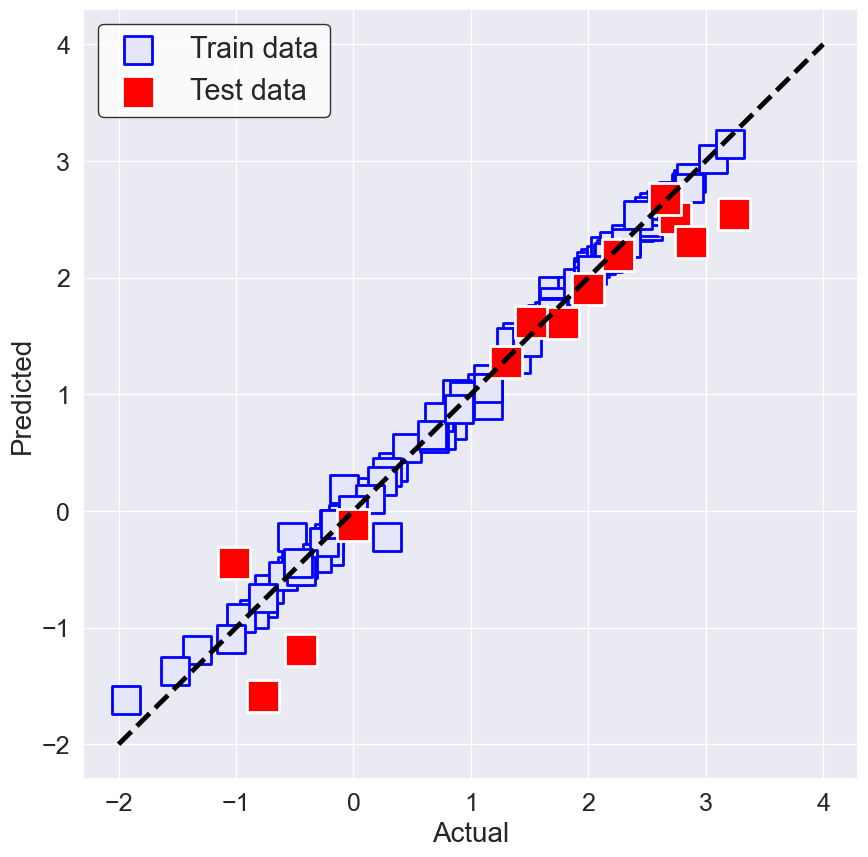

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Train data
plt.scatter(y_train, reg.predict(X_train), s=400, marker='s', linewidth=2,
            edgecolors="blue", label='Train data', color="lavender")

# Plot Test data
plt.scatter(y_test, reg.predict(X_test), s=500, marker='s', linewidth=2,
            edgecolors="white", label='Test data', color="red")

# Plot diagonal line
plt.plot([-2, 4], [-2, 4], linestyle='dashed', color='black', linewidth=3.5)

# Customize plot
plt.legend(loc='upper left', fontsize='xx-large', facecolor='w', edgecolor='black')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.show()

## 4. SHAPによる特徴量の解釈
SHAP (SHapley Additive exPlanations) を使用して、学習済みの回帰モデル reg の予測において、各特徴量がどのように貢献しているかを可視化するもので、各特徴量が予測結果に与える影響を知るために機械学習モデルの解釈性を高めるための手法として多く採用されています。

In [19]:
# SHAP feature importances
shap_values = shap.TreeExplainer(reg).shap_values(X_train)

### SHAP値の計算
```python
shap_values = shap.TreeExplainer(reg).shap_values(X_train)
```
- **`shap.TreeExplainer(reg)`**: `TreeExplainer` は、木構造ベースのモデル（ここでは `reg` という勾配ブースティング回帰モデル）に対して、SHAP値を計算するためのクラスです。`TreeExplainer` は特に、決定木ベースのモデル（例えばランダムフォレストや勾配ブースティング）に対して効率的にSHAP値を計算するために最適化されています。
  
- **`shap_values`**: これは、`X_train` の各データポイントに対するSHAP値を計算した結果です。SHAP値は、各特徴量が予測結果にどれだけ寄与しているかを示す値です。これにより、各特徴量がモデルの予測にどのような影響を与えているのかが分かります。

### SHAPサマリープロットの生成
下のプロットは、全サンプルのSHAP値の大きさの合計で特徴をソートし、SHAP値を使って各特徴がモデル出力に与える影響の分布を示します。
色は特徴値を表しています（赤が高く、青が低い）。SHAPサマリープロットは、以下の情報を提供します。
- 各特徴量の重要度（どれだけ予測に寄与しているか）
- 各特徴量の値が高い場合と低い場合に、どのようにモデルの予測に影響を与えているか

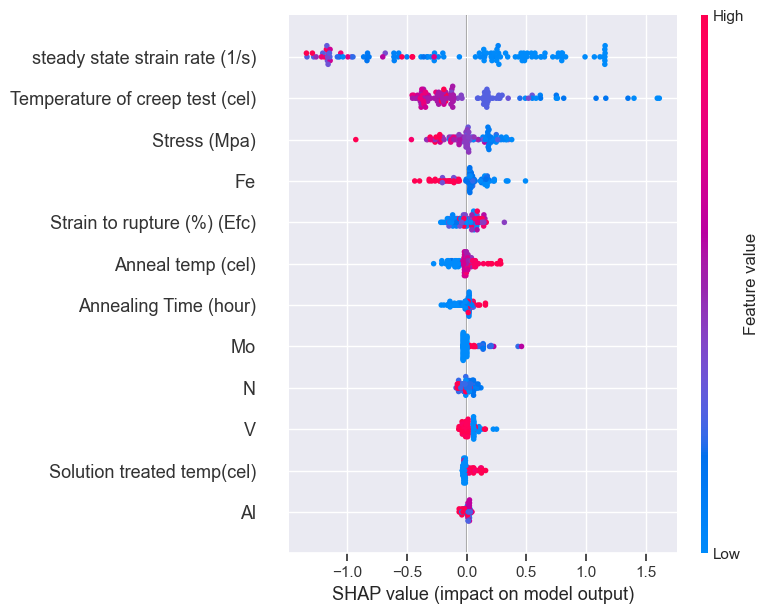

In [21]:
shap.summary_plot(shap_values, features = X_train, show=False)     

【解説】
```python
shap.summary_plot(shap_values, features = X_train, show=False)
```
- **`shap.summary_plot`**: これは、計算したSHAP値を基に、各特徴量の重要度や分布を可視化するサマリープロットを作成する関数です。
  
- **`shap_values`**: 計算したSHAP値をプロットに使用します。

- **`features = X_train`**: プロットに使用する特徴量データを指定します。ここではトレーニングデータ `X_train` が指定されています。

- **`show=False`**: プロットを作成しても自動的に表示しないように設定されています。これは、後で表示をコントロールしたい場合や、プロットを保存したい場合に便利です。

### SHAPサマリープロットの生成（棒グラフ）
特徴量の重要度を棒グラフで視覚化するものです。具体的には、各特徴量がモデルの予測にどの程度影響を与えているかを示すために、SHAP値の重要度を棒グラフとしてプロットしています。

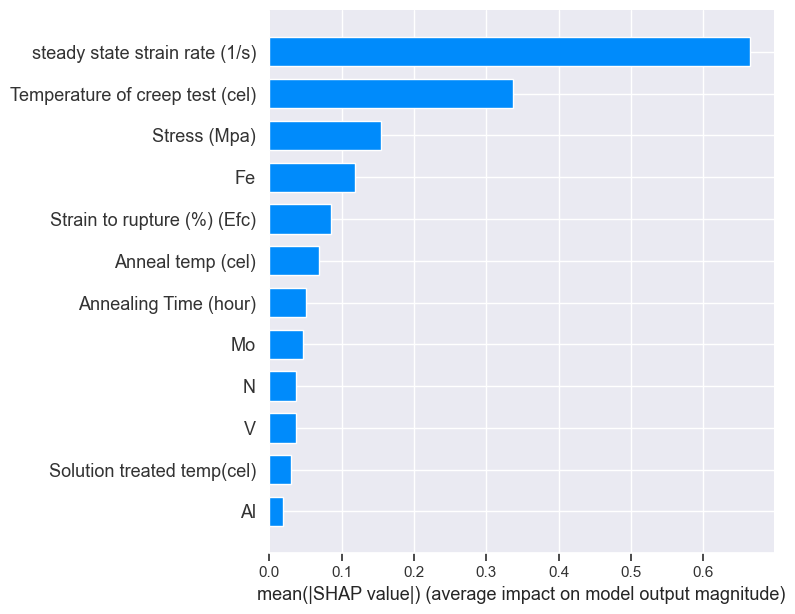

In [22]:
##----bar plot  
shap.summary_plot(shap_values, X_train, plot_type = "bar")  

### SHAP依存プロット
複数の特徴量に対するSHAP依存プロットは、モデルがどのように予測を行っているかを詳しく分析するためのものです。各特徴量がどのように予測に寄与しているか、また他の特徴量との相互作用がどのように影響を与えているかを視覚的に理解することができます。

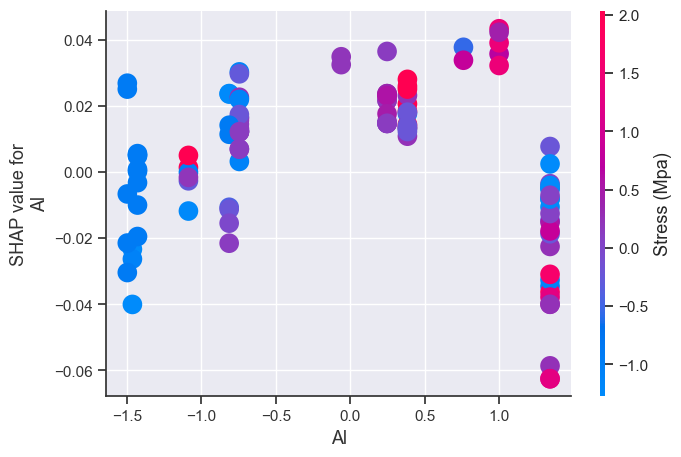

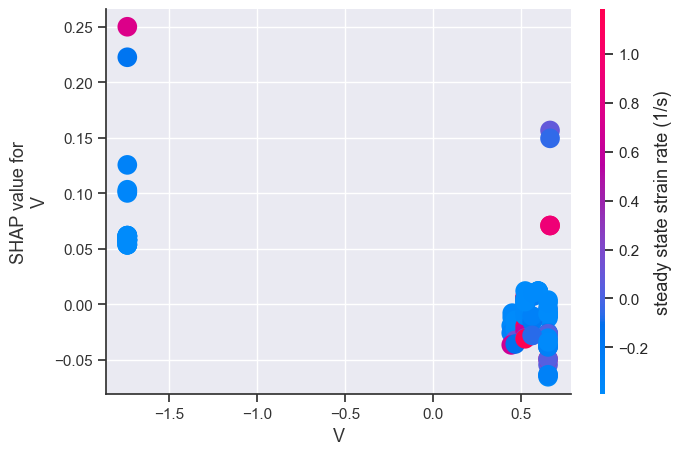

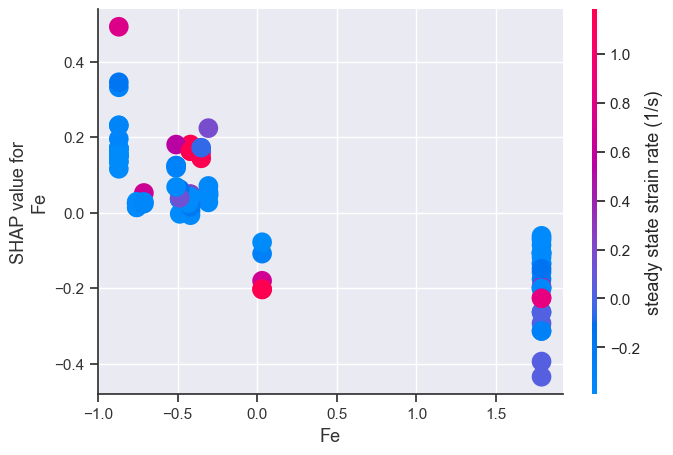

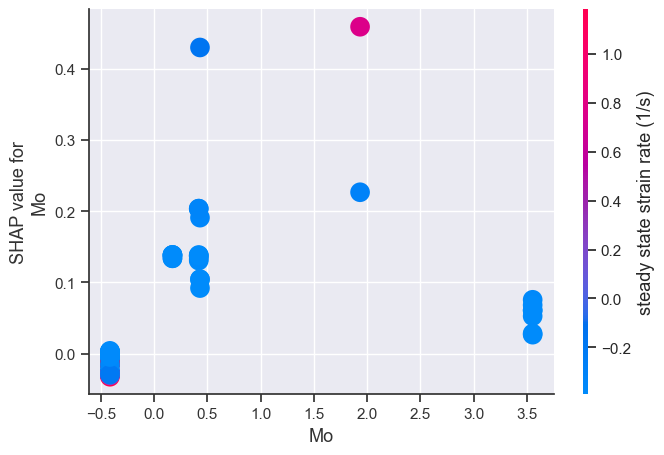

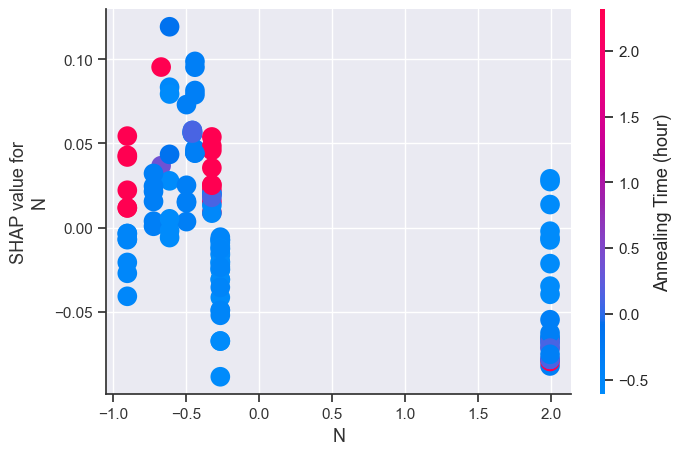

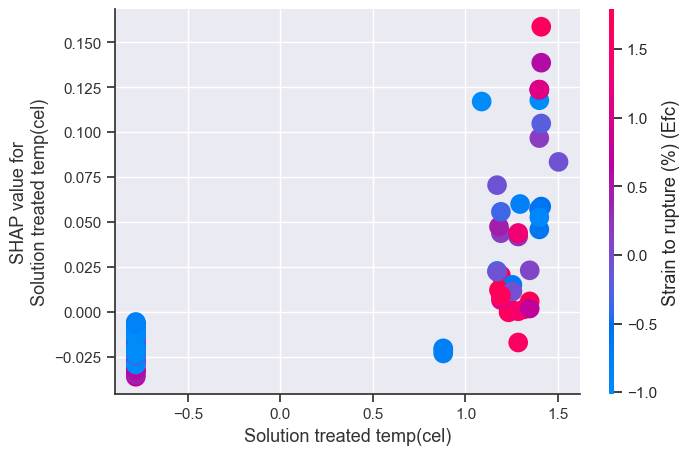

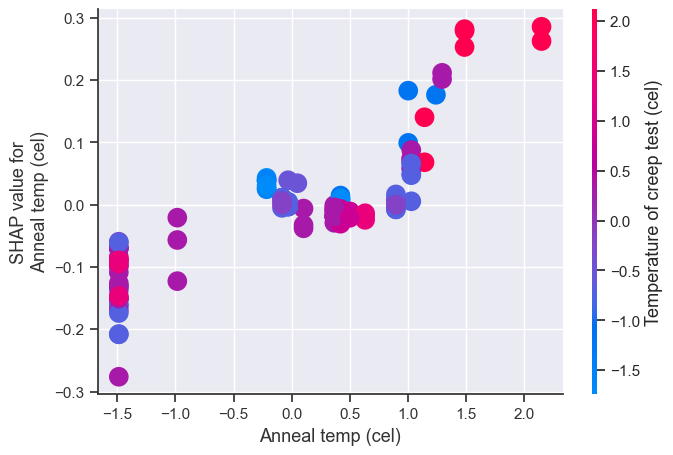

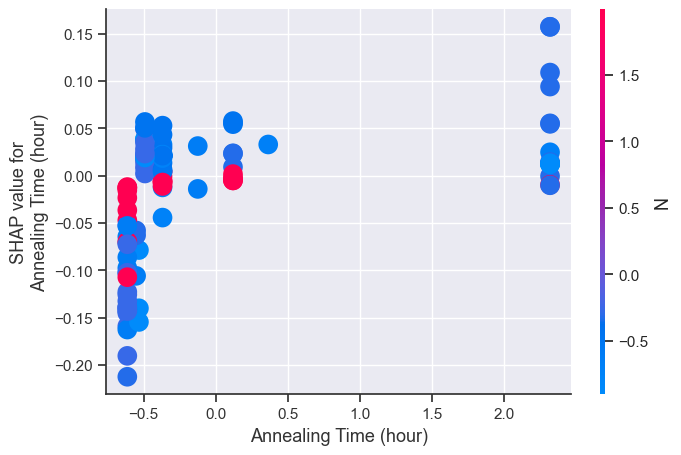

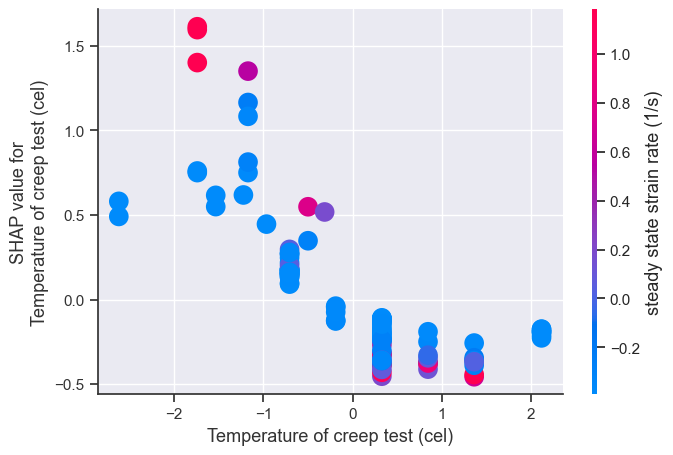

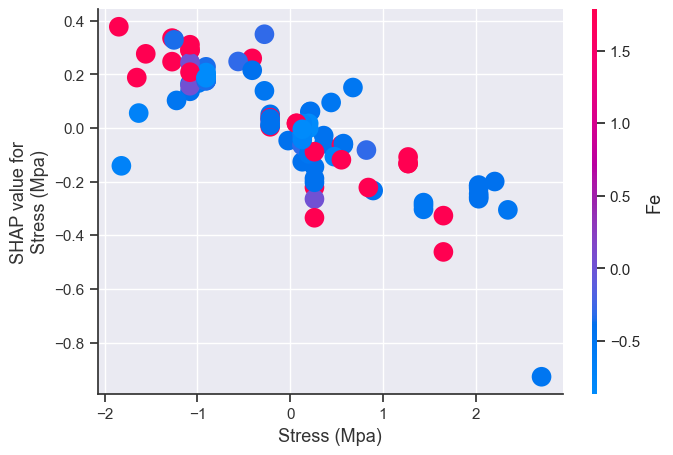

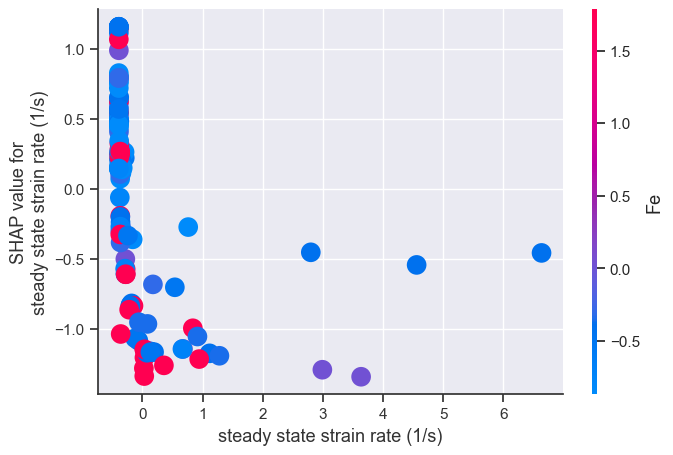

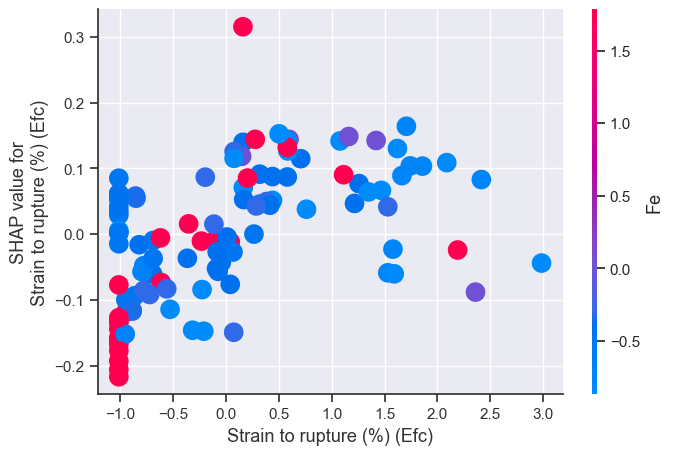

In [23]:
shap_values = shap.TreeExplainer(reg).shap_values(X_train)
for i in range(12):
    shap.dependence_plot(i, shap_values, X_train,show=False,
                      interaction_index='auto', dot_size=200)  